In [1]:
import matplotlib.pyplot as plt

import scipy as sp
import scipy.io
import numpy as np
import os
os.sys.path.append('../behavior')
os.sys.path.append('../')
from behavior_analysis import process_data as pd
from behavior_analysis import loadmat_sbx

import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import pandas 

from utilities import load_ca_mat, trial_tensor, across_trial_avg
import utilities
from scipy.ndimage.filters import gaussian_filter

%load_ext autoreload
%autoreload 2
%matplotlib inline

C:\Users\mplitt\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [15]:
CaDataDir = "Z://2P_data/2AFC_V3/4058541.1/CA1/"
mouse = "4058541.1"
CaFiles = ["CA1_001_004", "CA1_002_008", "CA1_003_002","CA1_004_002","CA1_005_001"] 
vr_dir = "Z://VR/2AFC_V3/"
BehaviorFiles = ["1_imaging_","2_imaging_3_",  "3_", "4_imaging_", "5_imaging_"]

In [40]:
vr_dir = "Z://VR/2AFC_V3/"
mouse = "4058541.3"
CaDataDir = "Z://2P_data/2AFC_V3/" + mouse + "/CA1//"
CaFiles = ["CA1_001_002" ,"CA1_002_002", "CA1_003_002","CA1_004_001","CA1_005_002"] 
BehaviorFiles = ["1_imaging_",  "2_", "3_", "4_imaging_", "5_imaging_"]

In [41]:
sessions, Behavior, C_list,TStartI,RewardI = [],[],[],[],[]

for i in range(len(CaFiles)):
    info = loadmat_sbx(CaDataDir + "/rawDat/" + CaFiles[i] + ".mat")['info']
    sess = "2AFC_Test_PostSurg_" + BehaviorFiles[i]
    m = pd(mouse,sess,basedir='work')
    if mouse=="4058541.3":
        behavior,tstart_inds,reward_inds,first_lick_inds = m.align_to_ca(sess,info,nplanes=2)
    else:
        behavior,tstart_inds,reward_inds,first_lick_inds = m.align_to_ca(sess,info,nplanes=1)
    fname= CaDataDir+ CaFiles[i] +"_cnmf_results.mat"
    print(fname)
    ca_dat = load_ca_mat(fname)
    
    #C = ca_dat['C_dec'][behavior['ca_inds'].values,:]
    C=sp.stats.zscore(ca_dat['C_dec'][behavior['ca_inds'].values,:],axis=0)
    sessions.append(sess)
    Behavior.append(behavior)
    C_list.append(C)
    TStartI.append(tstart_inds)
    RewardI.append(reward_inds)
    
    

        

Z://2P_data/2AFC_V3/4058541.3/CA1///rawDat/CA1_001_002.mat
(246,)
(246,)
(245, 4)
Z://2P_data/2AFC_V3/4058541.3/CA1//CA1_001_002_cnmf_results.mat
#subsystem#not made into numpy array
Z://2P_data/2AFC_V3/4058541.3/CA1///rawDat/CA1_002_002.mat
(246,)
(246,)
(245, 4)
Z://2P_data/2AFC_V3/4058541.3/CA1//CA1_002_002_cnmf_results.mat
#subsystem#not made into numpy array
Z://2P_data/2AFC_V3/4058541.3/CA1///rawDat/CA1_003_002.mat
(246,)
(246,)
(245, 4)
Z://2P_data/2AFC_V3/4058541.3/CA1//CA1_003_002_cnmf_results.mat
#subsystem#not made into numpy array
Z://2P_data/2AFC_V3/4058541.3/CA1///rawDat/CA1_004_001.mat
(246,)
(246,)
(245, 4)
Z://2P_data/2AFC_V3/4058541.3/CA1//CA1_004_001_cnmf_results.mat
#subsystem#not made into numpy array
Z://2P_data/2AFC_V3/4058541.3/CA1///rawDat/CA1_005_002.mat
(246,)
(246,)
(245, 4)
Z://2P_data/2AFC_V3/4058541.3/CA1//CA1_005_002_cnmf_results.mat
#subsystem#not made into numpy array


In [50]:
V_c, W_c = [],[]
V_p, W_p = [],[]
V_cp, W_cp = [],[]
nPosBins=34
for i in range(len(CaFiles)):
    C, behavior,tstart_inds = C_list[i], Behavior[i],TStartI[i]
    
    
    #make tensor (neuron x position x context - averaged over trials)
    T = np.zeros([C.shape[1],nPosBins,2])
    counter = np.zeros([2,])
    for val in [0, 1]:
        mask = behavior['morph'].values==val
        frmap, occupancy = utilities.rate_map(C[mask,:],behavior['position'].values[mask])
        #print(frmap.shape)
        T[:,:,val] = frmap.T
    
    
    # perform marginalizations
    t_,T_ = T.mean(axis=1).mean(axis=1),np.zeros(T.shape)
    print(t_.shape)
    for j in range(T.shape[0]):
        T_[j,:,:]=T[j,:,:]-t_[j]
   # T_ = T-T_   
    print(T_.shape)
    t_c, T_c = T_.mean(axis=1), np.zeros(T.shape)
    for j in range(T_.shape[1]):
        T_c[:,j,:] = t_c

    t_p, T_p = T_.mean(axis = 2), np.zeros(T.shape)
    for j in range(T_.shape[2]):
        T_p[:,:,j] = t_p

    T_cp = T_ - T_c - T_p

    T_ = T_.reshape([T.shape[0],-1])
    T_c = T_c.reshape([T.shape[0],-1]) 
    T_p = T_p.reshape([T.shape[0],-1])
    T_cp = T_cp.reshape([T.shape[0],-1])
    
    # solve for F and D with regularization
    lam = .00001
    Z = np.linalg.inv( np.dot(T_,T_.T) + np.dot((lam*np.linalg.norm(T_,ord='fro'))**2,np.eye(T.shape[0])))

    A_rr_c = np.dot(T_c,np.dot(T_.T,Z))
    A_rr_p = np.dot(T_p,np.dot(T_.T,Z))
    A_rr_cp = np.dot(T_cp,np.dot(T_.T,Z))
    
    pca = PCA()
    V_c.append(pca.fit_transform(A_rr_c))
    W_c.append(pca.singular_values_)

    V_p.append(pca.fit_transform(A_rr_p))
    W_p.append(pca.singular_values_)

    V_cp.append(pca.fit_transform(A_rr_cp))
    W_cp.append(pca.singular_values_)

(1195,)
(1195, 34, 2)
(1568,)
(1568, 34, 2)
(1762,)
(1762, 34, 2)
(1613,)
(1613, 34, 2)
(1661,)
(1661, 34, 2)


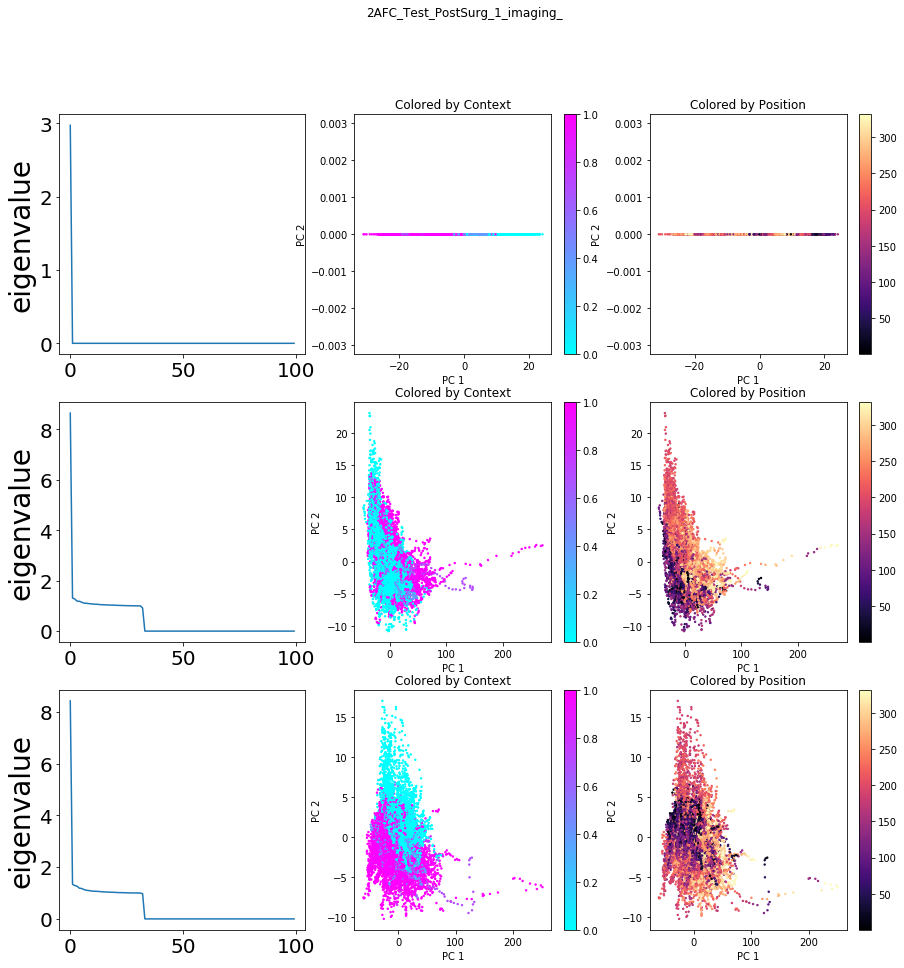

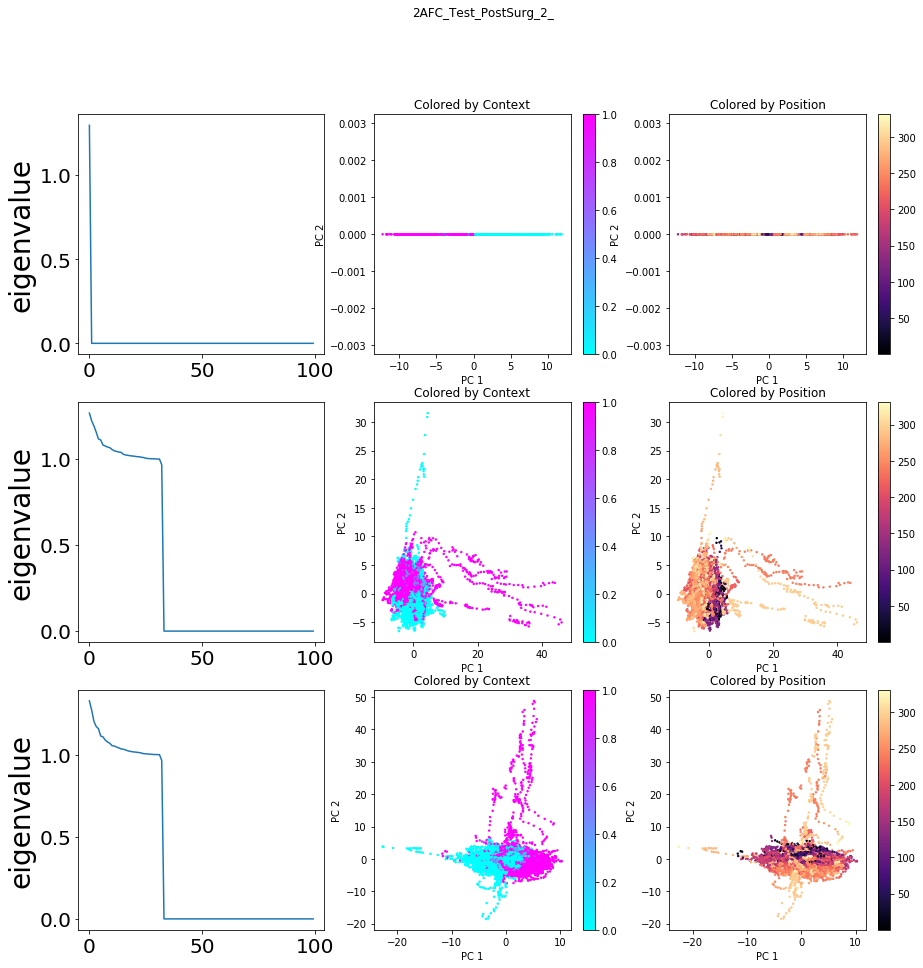

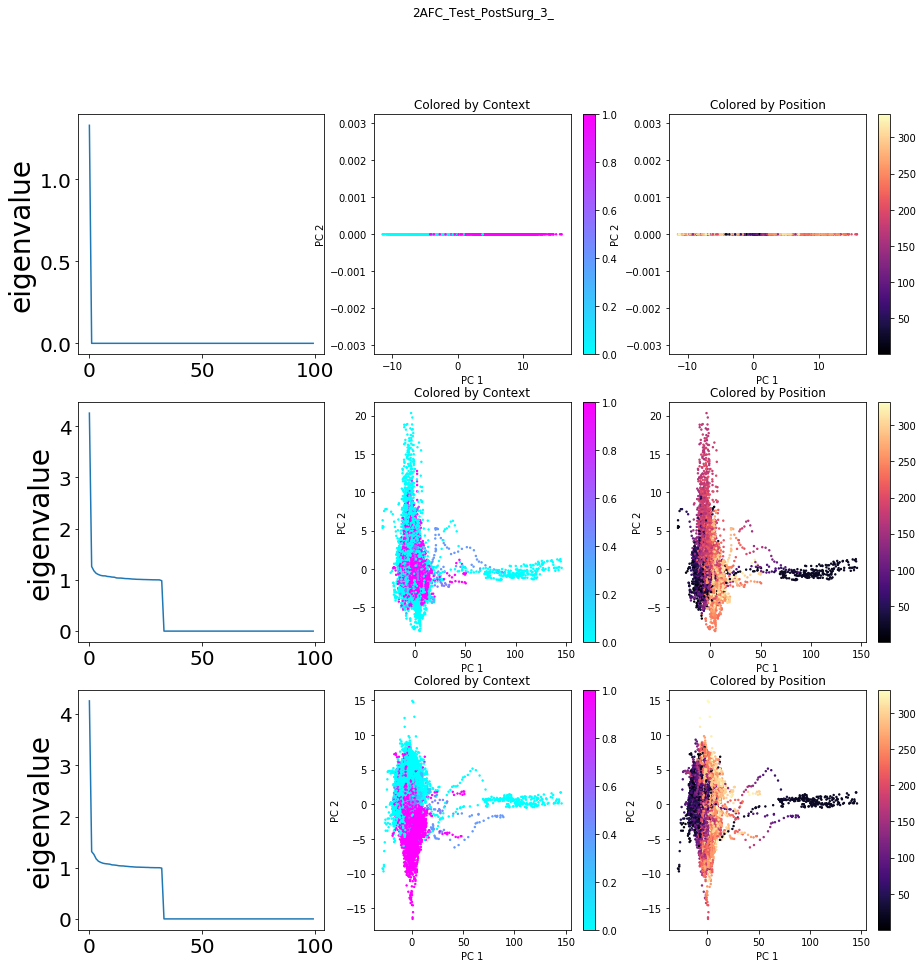

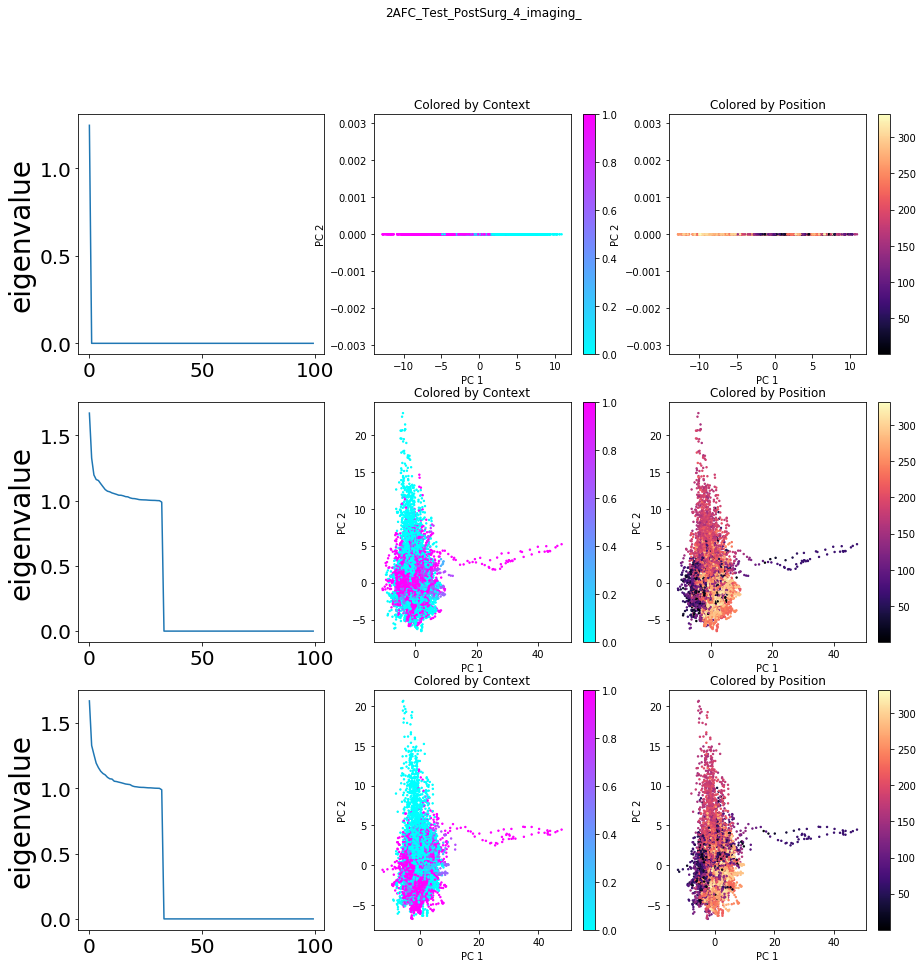

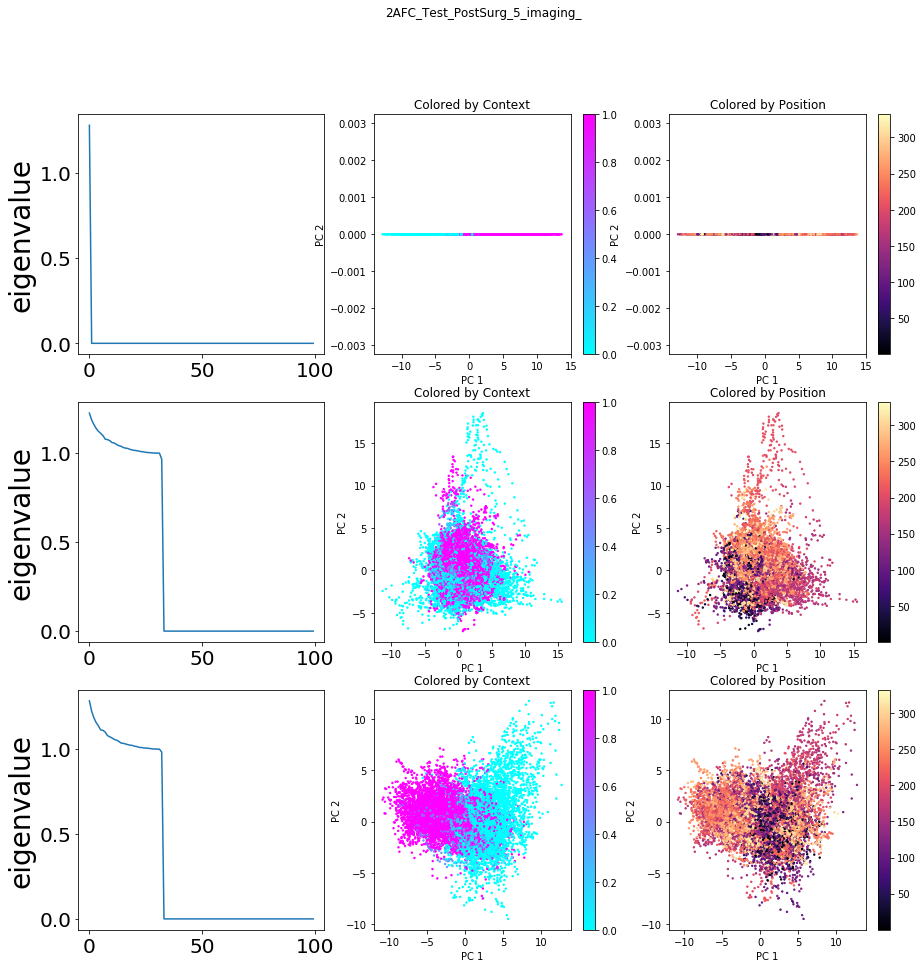

In [51]:

for i in range(len(CaFiles)):
    C, behavior,tstart_inds = C_list[i], Behavior[i],TStartI[i]
    v_c,v_p,v_cp =V_c[i],V_p[i],V_cp[i]
    w_c,w_p,w_cp =W_c[i],W_p[i],W_cp[i]

    C_c, C_p, C_cp = np.dot(C,v_c[:,:2]), np.dot(C,v_p[:,:2]), np.dot(C,v_cp[:,:2])

    f,axarr = plt.subplots(3,3,figsize=[15,15])
    
    plt.suptitle(sessions[i],figure= f,size='large')

    axarr[0,0].plot(w_c[:100])
    axarr[0,0].set_ylabel("eigenvalue",size=28)
    axarr[0,0].tick_params(labelsize=20)


    trialMask = Behavior[i]['position'].values>0
    context_trialMask = (Behavior[i]['position'].values>0) & (Behavior[i]['morph'].values!=0) &(Behavior[i]['morph'].values!=1)

    s_cxt=axarr[0,1].scatter(C_c[trialMask,0],C_c[trialMask,1],c=Behavior[i]['morph'].values[trialMask],cmap='cool',s=2)
    plt.colorbar(s_cxt,ax=axarr[0,1])
    axarr[0,1].set_title('Colored by Context')
    axarr[0,1].set_xlabel("PC 1")
    axarr[0,1].set_ylabel("PC 2")

    s_pos=axarr[0,2].scatter(C_c[trialMask,0],C_c[trialMask,1],c=Behavior[i]['position'].values[trialMask],cmap='magma',s=2)
    plt.colorbar(s_pos,ax=axarr[0,2])
    axarr[0,2].set_title('Colored by Position')
    axarr[0,2].set_xlabel("PC 1")
    axarr[0,2].set_ylabel("PC 2")
    
    
    axarr[1,0].plot(w_p[:100])
    axarr[1,0].set_ylabel("eigenvalue",size=28)
    axarr[1,0].tick_params(labelsize=20)


    s_cxt=axarr[1,1].scatter(C_p[trialMask,0],C_p[trialMask,1],c=Behavior[i]['morph'].values[trialMask],cmap='cool',s=2)
    plt.colorbar(s_cxt,ax=axarr[1,1])
    axarr[1,1].set_title('Colored by Context')
    axarr[1,1].set_xlabel("PC 1")
    axarr[1,1].set_ylabel("PC 2")

    s_pos=axarr[1,2].scatter(C_p[trialMask,0],C_p[trialMask,1],c=Behavior[i]['position'].values[trialMask],cmap='magma',s=2)
    plt.colorbar(s_pos,ax=axarr[1,2])
    axarr[1,2].set_title('Colored by Position')
    axarr[1,2].set_xlabel("PC 1")
    axarr[1,2].set_ylabel("PC 2")
    
    axarr[2,0].plot(w_cp[:100])
    axarr[2,0].set_ylabel("eigenvalue",size=28)
    axarr[2,0].tick_params(labelsize=20)


    s_cxt=axarr[2,1].scatter(C_cp[trialMask,0],C_cp[trialMask,1],c=Behavior[i]['morph'].values[trialMask],cmap='cool',s=2)
    plt.colorbar(s_cxt,ax=axarr[2,1])
    axarr[2,1].set_title('Colored by Context')
    axarr[2,1].set_xlabel("PC 1")
    axarr[2,1].set_ylabel("PC 2")

    s_pos=axarr[2,2].scatter(C_cp[trialMask,0],C_cp[trialMask,1],c=Behavior[i]['position'].values[trialMask],cmap='magma',s=2)
    plt.colorbar(s_pos,ax=axarr[2,2])
    axarr[2,2].set_title('Colored by Position')
    axarr[2,2].set_xlabel("PC 1")
    axarr[2,2].set_ylabel("PC 2")

